In [1]:
import csv
import random
import os
from IPython.display import clear_output
from sklearn.preprocessing import RobustScaler, MinMaxScaler, normalize
from sklearn import preprocessing
import librosa
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

filename = './BMD-HS-Dataset/train.csv'

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [3]:
print(torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

2.6.0+cu126


In [4]:
with open(filename) as f:
    reader = csv.reader(f)
    chosen_row = random.choice(list(reader))

print(chosen_row[6])

AS_064_sup_Mit


In [5]:
filename = os.path.join('.', 'BMD-HS-Dataset', 'train', chosen_row[6] + '.wav')

In [6]:
req_len = 20
num_features = 1024
window = 256
n_mels = 256
mel_effective_part = 64
AUSC_LAYERS = 8

data, rate = librosa.load(filename, sr=None, mono=True)
req_samples = req_len * rate
if(rate*len(data) > req_len):
  data = data[(len(data) - req_samples) // 2:req_samples + (len(data) - req_samples) // 2]
elif (rate*len(data) < req_len):
  data = np.pad(data, ((req_samples - len(data)) // 2))

data = normalize(data[:,np.newaxis], axis=0, norm='max').ravel()

print(data)
print(len(data)/rate, rate, len(data))

[ 0.          0.          0.         ... -0.01147496 -0.0118717
 -0.01223792]
20.0 4000 80000


In [7]:
t = np.arange (0, len(data)/rate, 1/rate)
print(t, len(t)/rate)

[0.000000e+00 2.500000e-04 5.000000e-04 ... 1.999925e+01 1.999950e+01
 1.999975e+01] 20.0


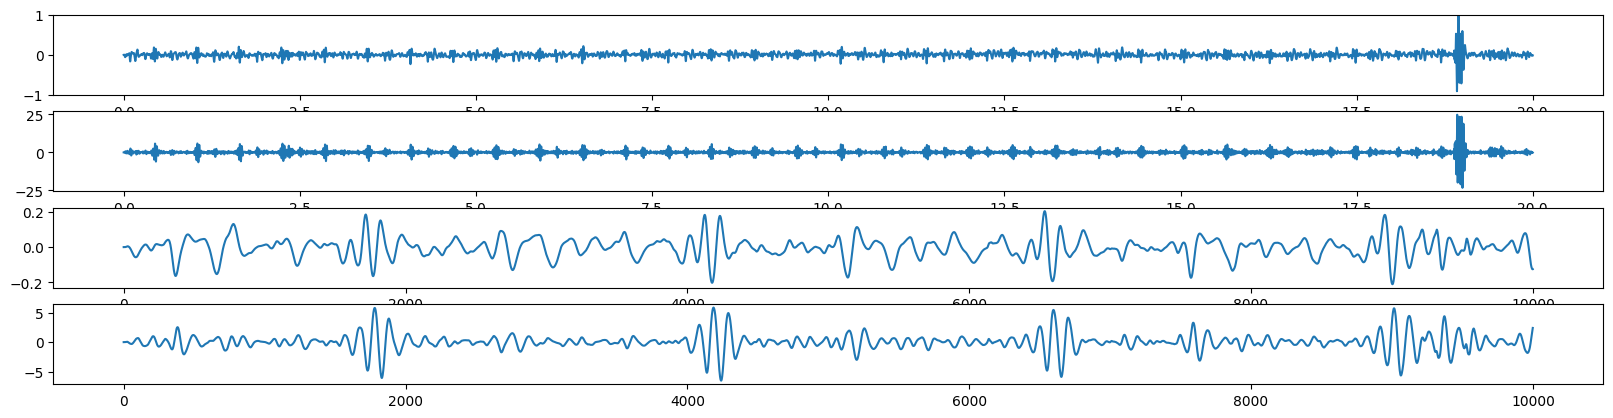

In [8]:
# scaler = preprocessing.MinMaxScaler()
# scaler = preprocessing.MaxAbsScaler()
# scaler = preprocessing.StandardScaler()
scaler = preprocessing.RobustScaler()

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4)

ax0.plot(t, data)
sos = signal.ellip(3, 1, 500, 9, 'hp', fs=1000, output='sos')
data_filtered = signal.sosfilt(sos, data)

data_filtered = scaler.fit_transform(data_filtered[:, np.newaxis])

ax1.plot(t, data_filtered)

ax2.plot(data[0:400 * 25])
ax3.plot(data_filtered[0:400 * 25])

fig.set_figwidth(20)
ax0.set_ybound(-1, 1)
plt.show()

In [9]:
def filter_data(data : np.ndarray):
  retdata = data
  sos = signal.ellip(3, 1, 500, 9, 'hp', fs=1000, output='sos')
  retdata = signal.sosfilt(sos, retdata)
  retdata = scaler.fit_transform(retdata[:, np.newaxis])
  return retdata

def get_waveform_energy_seq(data : np.ndarray, window : int):
  energy_seq = np.array([])
  for i in range(len(data) // window):
    energy_sum = 0
    for element in data[i * window : (i + 1) * window]:
      energy_sum += element**2
    energy_seq = np.append(energy_seq, energy_sum)
  return energy_seq

def get_cut_data(data : np.ndarray, pad : int = 0, window : int = 100, peak_h : float = 0.8, npeaks : int = 3, time : float = 10, out : str = 'time', rate : int = 1000):
  scaler = preprocessing.MinMaxScaler()
  
  peak_dots = [[0, 0]]
  energy_seq = []

  ret_data = data[pad:]
  filt_data = filter_data(data[pad:])
  energy_seq = get_waveform_energy_seq(filt_data, window)
        
  energies_mean = np.array(energy_seq).mean()
  energies_dev = np.std(energy_seq)
  z_scores = (energy_seq - energies_mean) / energies_dev
  energy_seq = np.array(scaler.fit_transform(z_scores[:, np.newaxis])).flatten()

  for i in range(len(energy_seq)): # cut untill face first high cardiac impulse
    if peak_h < energy_seq[i]: 
      peak_dots[0][1] = energy_seq[i]
      break
  ret_data = ret_data[i * window:]
  energy_seq = energy_seq[i :]
  
  if(out == 'npeaks'):
    pad_pos = 0
    for _ in range(npeaks):
      for i in range(pad_pos + 1, len(energy_seq)):
        if energy_seq[i] > peak_h: break
      pad_pos = i
      peak_dots.append([i, energy_seq[i]])
    ret_data = ret_data[:(i + 1) * window]
    energy_seq = energy_seq[: (i+1)]
  elif(out == 'time'):
    ret_data = ret_data[:int(rate * time) + 1]
    energy_seq = energy_seq[:int(rate * time / window) + 1]

  return ret_data, energy_seq, np.array(peak_dots)

def get_specgram(data : np.ndarray, num_features : int, rate : int, window : int, n_mels : int):
  Pxx = librosa.stft(data, dtype=np.float32, n_fft=num_features, win_length=window)
  Pxx, _ = librosa.magphase(Pxx)
  Pxx = librosa.feature.melspectrogram(S=Pxx, sr=rate, n_fft=num_features, n_mels=n_mels)
  Pxx = librosa.amplitude_to_db(Pxx, ref=np.min)
  return Pxx

(80000,)
(256, 1251)


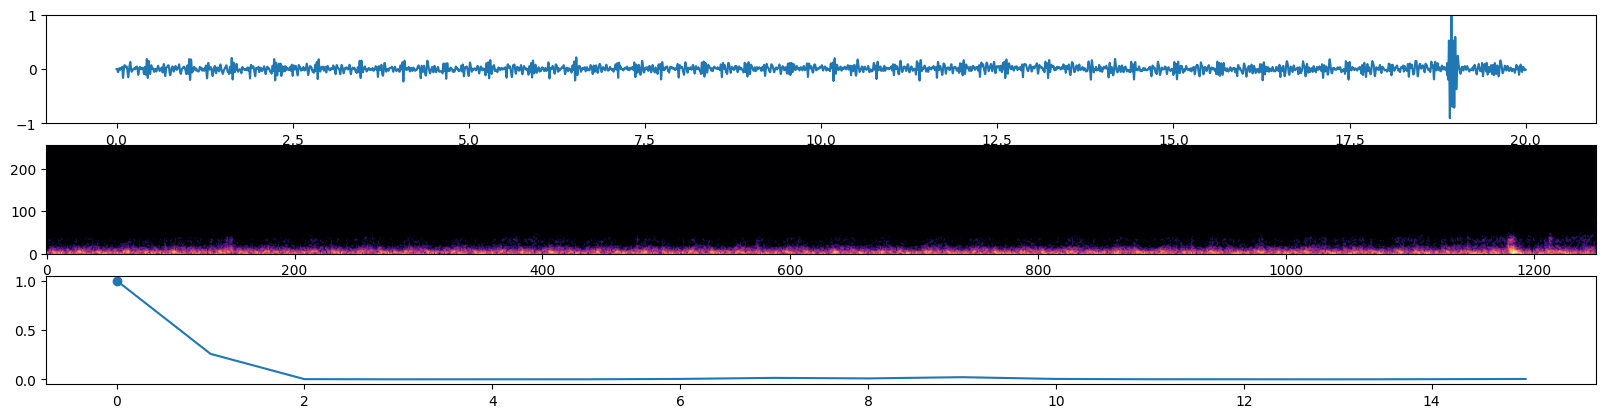

In [10]:
import warnings 
warnings.filterwarnings('ignore')

fig, axs = plt.subplots(nrows=3, ncols=1, sharex=False)

axs[0].plot(t, data)
data_cut, energy, dots = get_cut_data(data, window=256, peak_h=0.35, time=5, out='time', rate=rate)
print(data.shape)
data_cut = get_specgram(data, num_features, rate, window, n_mels)#[:mel_effective_part]
print(data_cut.shape)
axs[1].imshow(data_cut, origin='lower', cmap='magma', aspect='auto')
axs[2].plot(energy)
axs[2].scatter(dots[:,0], dots[:,1])

fig.set_figwidth(20)
axs[0].set_ybound(-1, 1)
# ax1.set_xticks(range(0, len(data_cut), 400))
plt.show()

In [11]:
%matplotlib inline 
#pip install jupyter ipympl - for this

def live_plot(data, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.plot(data)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show()

# arr = []
# for i in range (100):
#   arr.append(i**2)
#   live_plot(arr)


In [12]:

class SinglePatientData:
  def __init__(self, names : list, flags : list):
    self.contents = {
              'sup_mit_file_name' : '', 
              'sup_tri_file_name' : '' , 
              'sup_pul_file_name' : '' , 
              'sup_aor_file_name' : '' ,
              'sit_mit_file_name' : '' , 
              'sit_tri_file_name' : '' , 
              'sit_pul_file_name' : '' , 
              'sit_aor_file_name' : '' ,}
  
    self.diagnosis_flags = {'AorticStenosis' : 0, 
                      'AorticRegurgitation' : 0,
                      'Mitral Regirgitation' : 0,
                      'Mitral Stenosis' : 0,
                      'Normal' : 0}
    i = 0
    for key in self.contents:
      try: #todo
        self.contents[key] = names[i];
      except:
        self.contents[key] = ''
      finally:
        i += 1
    i = 0
    for key in self.diagnosis_flags:
      try:
        self.diagnosis_flags[key] = int(flags[i]);
      except:
        self.diagnosis_flags[key] = 0
      finally:
        i += 1
  def getTensor(self, path): # returns 129x1249x5 torch tensor
    if (hasattr(self, 'specgrams')):
      return self.specgrams
    else:
      returned_tensor = []
      for name in list(self.contents.values()):
        req_len = 20
        data, rate = librosa.load(os.path.join(path, name + '.wav'), sr=None, mono=True)
        req_samples = req_len * rate
        if(len(data) > req_len * rate):
          data = data[(len(data) - req_samples) // 2:req_samples + (len(data) - req_samples) // 2]
        elif (len(data) < req_len * rate):
          data = np.pad(data, ((req_samples - len(data)) // 2))
        
        data = normalize(data[:,np.newaxis], axis=0, norm='max').ravel()
        # data, _, _ = get_cut_data(data, window=256, peak_h=0.35, time=3, out='time')
        data = get_specgram(data, num_features, rate, window, n_mels)#[:mel_effective_part]
        data = data.transpose()

        returned_tensor.append(data)
      returned_tensor = np.array(returned_tensor, dtype=np.float32)
      self.specgrams = torch.from_numpy(returned_tensor)
      return self.specgrams
    

In [13]:
def createDataArray(csvFilename):
  with open(csvFilename) as file:
    retArray = []
    reader = csv.reader(file, delimiter=',')
    reader.__next__() 
    for row in reader:
      retArray.append(SinglePatientData(list(row[6 : ]), list(row[1: 6])))
    return retArray

In [14]:
class RnnModel(nn.Module):
    def __init__(self):
        super(RnnModel, self).__init__()
        rec_layers = []
        conv_layers = []
        lin_layers = []

        self.rnn1 = nn.LSTM(
            input_size=n_mels * AUSC_LAYERS, #mel_effective_part * AUSC_LAYERS,
            hidden_size=n_mels * AUSC_LAYERS, #mel_effective_part * AUSC_LAYERS,
            num_layers=10,
            batch_first=True,
        )
        self.relu1 = nn.ReLU()

        rec_layers += [self.rnn1]

        self.conv2 = nn.Conv1d(1, 8, kernel_size=2, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv1d(8, 16, kernel_size=2, stride=2, padding=2)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv1d(16, 16, kernel_size=3, stride=2, padding=2)
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv1d(16, 32, kernel_size=5, stride=3, padding=2)
        self.relu5 = nn.ReLU()
        self.conv6 = nn.Conv1d(32, 64, kernel_size=2, stride=2, padding=2)
        self.relu6 = nn.ReLU()
        self.ap = nn.AdaptiveAvgPool1d(output_size=1)

        conv_layers += [self.conv2, self.relu2,
                        self.conv3, self.relu3,
                        self.conv4, self.relu4,
                        self.conv5, self.relu5,
                        self.conv6, self.relu6, self.ap]
        self.conv_layers = nn.Sequential(*conv_layers)
        

        self.fc7 = nn.Linear(in_features=64, out_features=32)
        self.relu7 = nn.ReLU()
        self.fc8 = nn.Linear(in_features=32, out_features=5)
        self.relu8 = nn.ReLU()

        lin_layers += [self.fc7, self.relu7,
                       self.fc8, self.relu8]
        self.lin_layers = nn.Sequential(*lin_layers)


    def forward(self, x):

        out, _ = self.rnn1(x)
        out = self.relu1(out[-1])
        out = self.conv_layers(torch.unsqueeze(out, 0))
        out = self.lin_layers(out.flatten())
        return out

In [15]:
foldername = os.path.join('.', 'BMD-HS-Dataset')
trainFoldername = os.path.join(foldername, 'train')
trainCsvName = os.path.join(foldername, 'train.csv')

dataArray = createDataArray(trainCsvName)
dataIterator = iter(dataArray)

In [16]:
model = RnnModel().to(device)
Pxx = torch.transpose(next(dataIterator).getTensor(trainFoldername).to(device), 0, 1)
Pxx = torch.reshape(Pxx, (Pxx.shape[0], n_mels * AUSC_LAYERS))
# Pxx = torch.unsqueeze(Pxx, dim=0)
print(Pxx.shape)
out = model(Pxx)
print(out.shape) 


torch.Size([1251, 2048])
torch.Size([5])


In [17]:
learning_rate = 0.001
num_epochs = 200

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = RnnModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
def get_acc(logit, target):
    ''' Check if answer is right for training round '''
    round_logit = torch.round(logit)
    acc = 0
    for i in range(len(target)):
        ans = (1 if 0 <= int(round_logit[i].item()) else 0)
        acc += (1 if ans == int(target[i].item()) else 0)
    return acc / len(target)

In [19]:
train_acc = 0
epoch = 0
accuracies = []
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    random.shuffle(dataArray)
    dataIterator = iter(dataArray)
    ## training step
    for i, patient in enumerate(dataIterator):
        labels = torch.tensor(list(patient.diagnosis_flags.values()), dtype=torch.float32).to(device)
        # labels = torch.unsqueeze(labels, dim=0)

        Pxx = patient.getTensor(trainFoldername)

        ## forward + backprop + loss
        # Pxx = torch.transpose(next(dataIterator).getTensor(trainFoldername), 0, 1).to(device)
        Pxx = torch.transpose(next(dataIterator).getTensor(trainFoldername).to(device), 0, 1)
        Pxx = torch.reshape(Pxx, (Pxx.shape[0], mel_effective_part * AUSC_LAYERS))
        # Pxx = torch.unsqueeze(Pxx, dim=0)

        logits = model(Pxx)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_acc(logits, labels)
        # print('Loss curr: %.4f, loss mean: %.4f' %(loss.detach().item(), train_running_loss / (i + 1)))
        # print('target: %s, logits: %s, loss: %f' %(labels, logits, train_running_loss / (i + 1), train_acc / (i + 1)))
        print(labels.cpu().detach().numpy(), '\n', logits.cpu().detach().numpy(), train_running_loss / (i+1))


    model.eval()
    accuracies += [train_running_loss / i]
    live_plot(accuracies)
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))

RuntimeError: shape '[1251, 512]' is invalid for input of size 2562048